## 1. Goal

To evaluate how much classification performance drops occurs in the absence of the top-ranked feature ('URLSimilarityIndex')

- Readout: Classification accuracy and F1-score

- Dataset: ~10% of the whole dataset (20000 URLs = 10000 legitimate and 10000 phishing URLs)


## 2. Pre-processing
- Select the top feature columns (18 columns)
- Drop the top 1 feature column
- Remove label (1 column) and store as a separate vector
- Normalize columns with a range of 0 to 1
- Perform Train-test-split with 80:20 ratio


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Allow Google Colab to access to Google Drive (Mount)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# read csv files
dataset = pd.read_csv('/content/drive/My Drive/00. BU BME/05. Spring 2024 (EC503)/Project/PhiUSIIL Phishing URL/PhiUSIIL_Phishing_URL_Dataset.csv')
top_feature_combined = pd.read_csv('/content/drive/My Drive/00. BU BME/05. Spring 2024 (EC503)/Project/PhiUSIIL Phishing URL/top_feature_combined.csv')
top_feature_combined = top_feature_combined.drop(top_feature_combined[top_feature_combined['Feature']=='URLSimilarityIndex'].index) # drop the top feature

# Separating data points based on their labels
y = dataset['label']
X_class_0 = dataset[y == 0]
X_class_1 = dataset[y == 1]

# Randomly sampling 1000 points from each class
np.random.seed(42)
sampled_indices_class_0 = np.random.choice(len(X_class_0), size=10000, replace=False)
sampled_indices_class_1 = np.random.choice(len(X_class_1), size=10000, replace=False)

# Extracting the sampled data points
X_sampled_class_0 = X_class_0.iloc[sampled_indices_class_0]
X_sampled_class_1 = X_class_1.iloc[sampled_indices_class_1]

# Combining the sampled data points
X_sampled = pd.concat([X_sampled_class_0, X_sampled_class_1], axis=0)
y = np.concatenate([np.zeros(len(X_sampled_class_0)), np.ones(len(X_sampled_class_1))])

# Select top features and labels for training
# Exclude the top feature ('URLSimilarityIndex')
No_Top1_df = X_sampled[top_feature_combined['Feature']]

# Define a function to normalize numerical columns
def normalize_columns(df):
    return (df - df.min()) / (df.max() - df.min())

# Apply normalization to all columns
normalized_No_Top1_df = normalize_columns(No_Top1_df)

normalized_No_Top1_df, y

(        HasSocialNet  LineOfCode  NoOfExternalRef  NoOfSelfRef  NoOfImage  \
 170643           0.0    0.000000         0.000000     0.000000   0.000000   
 229388           0.0    0.000083         0.000075     0.000000   0.000000   
 189747           0.0    0.001408         0.000075     0.000000   0.000599   
 39922            0.0    0.000000         0.000000     0.000000   0.000000   
 172005           0.0    0.004997         0.000600     0.000000   0.000000   
 ...              ...         ...              ...          ...        ...   
 81155            0.0    0.004285         0.009679     0.035045   0.007792   
 144617           1.0    0.003233         0.003151     0.011782   0.000799   
 110146           1.0    0.003944         0.000750     0.000000   0.003397   
 235694           0.0    0.002309         0.000750     0.004834   0.000799   
 144475           1.0    0.015875         0.013881     0.052266   0.011988   
 
         HasCopyrightInfo    NoOfJS  HasDescription  IsHTTPS  

In [7]:
# Train-test-split by 80:20
X = normalized_No_Top1_df

# Perform train-test-split with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the train and test sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (16000, 17)
Shape of X_test: (4000, 17)
Shape of y_train: (16000,)
Shape of y_test: (4000,)


## 3. Evaluation of phishing detection based on varying number of features
- Two classifiers: RandomForest and SVM
- The number of top features: 1,3,5,7,10, and 17 (maximum number)
- High-rank features are selected first
- Compute average performance using 5-fold cross-validation

In [8]:
# Define a function to select top features
def select_top_features(X, y, num_features):
    # Select top features based on rankings
    top_features = top_feature_combined.head(num_features)['Feature']
    X_selected = X[top_features]
    return X_selected

# Define a function to train and evaluate classifiers
def train_and_evaluate(X_train, X_test, y_train, y_test, classifier):
    # Train classifier
    classifier.fit(X_train, y_train)

    # Predict on test set
    y_pred = classifier.predict(X_test)

    # Calculate accuracy and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, f1

# Define the numbers of top features to evaluate
num_features_list = [1, 3, 5, 7, 10, 17]


# Initialize classifiers
rf_classifier = RandomForestClassifier(random_state=42)
svm_classifier = SVC(random_state=42)

# Initialize lists to store results
rf_accuracies = []
rf_f1_scores = []
svm_accuracies = []
svm_f1_scores = []

# Iterate over the numbers of top features
for num_features in num_features_list:
    # Select top features
    X_train_selected = select_top_features(X_train, y_train, num_features)
    X_test_selected = select_top_features(X_test, y_test, num_features)

    # Train and evaluate RandomForest classifier
    rf_accuracy, rf_f1 = train_and_evaluate(X_train_selected, X_test_selected, y_train, y_test, rf_classifier)
    rf_accuracies.append(rf_accuracy)
    rf_f1_scores.append(rf_f1)

    # Train and evaluate SVM classifier
    svm_accuracy, svm_f1 = train_and_evaluate(X_train_selected, X_test_selected, y_train, y_test, svm_classifier)
    svm_accuracies.append(svm_accuracy)
    svm_f1_scores.append(svm_f1)

# Print results
print("RandomForest Classifier:")
for i, num_features in enumerate(num_features_list):
    print(f"Top {num_features} features - Accuracy: {rf_accuracies[i]}, F1-score: {rf_f1_scores[i]}")

print("\nSVM Classifier:")
for i, num_features in enumerate(num_features_list):
    print(f"Top {num_features} features - Accuracy: {svm_accuracies[i]}, F1-score: {svm_f1_scores[i]}")

RandomForest Classifier:
Top 1 features - Accuracy: 0.89675, F1-score: 0.8846046381670858
Top 3 features - Accuracy: 0.98475, F1-score: 0.9846540880503145
Top 5 features - Accuracy: 0.99, F1-score: 0.9899142713061019
Top 7 features - Accuracy: 0.98975, F1-score: 0.9896595208070617
Top 10 features - Accuracy: 0.994, F1-score: 0.9939516129032258
Top 17 features - Accuracy: 0.99725, F1-score: 0.9972257250945776

SVM Classifier:
Top 1 features - Accuracy: 0.89675, F1-score: 0.8846046381670858
Top 3 features - Accuracy: 0.9075, F1-score: 0.8978464936499172
Top 5 features - Accuracy: 0.9465, F1-score: 0.94350580781415
Top 7 features - Accuracy: 0.947, F1-score: 0.9468671679197995
Top 10 features - Accuracy: 0.97625, F1-score: 0.9760161575359758
Top 17 features - Accuracy: 0.981, F1-score: 0.9806812404677173


In [9]:
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

# Define a function to perform cross-validation and compute metrics
def cross_validate(X, y, classifier, num_features):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = cross_val_score(classifier, X, y, cv=kf, scoring='accuracy')
    f1_scores = cross_val_score(classifier, X, y, cv=kf, scoring='f1')
    return np.mean(accuracy_scores), np.std(accuracy_scores), np.mean(f1_scores), np.std(f1_scores)

# Initialize classifiers
rf_classifier = RandomForestClassifier(random_state=42)
svm_classifier = SVC(random_state=42)

# Initialize lists to store results
rf_accuracy_means = []
rf_accuracy_stds = []
rf_f1_means = []
rf_f1_stds = []
svm_accuracy_means = []
svm_accuracy_stds = []
svm_f1_means = []
svm_f1_stds = []

# Iterate over the numbers of top features
for num_features in num_features_list:
    # Select top features
    X_selected = select_top_features(X, y, num_features)

    # Cross-validate RandomForest classifier
    rf_accuracy_mean, rf_accuracy_std, rf_f1_mean, rf_f1_std = cross_validate(X_selected, y, rf_classifier, num_features)
    rf_accuracy_means.append(rf_accuracy_mean)
    rf_accuracy_stds.append(rf_accuracy_std)
    rf_f1_means.append(rf_f1_mean)
    rf_f1_stds.append(rf_f1_std)

    # Cross-validate SVM classifier
    svm_accuracy_mean, svm_accuracy_std, svm_f1_mean, svm_f1_std = cross_validate(X_selected, y, svm_classifier, num_features)
    svm_accuracy_means.append(svm_accuracy_mean)
    svm_accuracy_stds.append(svm_accuracy_std)
    svm_f1_means.append(svm_f1_mean)
    svm_f1_stds.append(svm_f1_std)

# Print results
print("RandomForest Classifier:")
for i, num_features in enumerate(num_features_list):
    print(f"Top {num_features} features - Average Accuracy: {rf_accuracy_means[i]}, Std: {rf_accuracy_stds[i]}, Average F1-score: {rf_f1_means[i]}, Std: {rf_f1_stds[i]}")

print("\nSVM Classifier:")
for i, num_features in enumerate(num_features_list):
    print(f"Top {num_features} features - Average Accuracy: {svm_accuracy_means[i]}, Std: {svm_accuracy_stds[i]}, Average F1-score: {svm_f1_means[i]}, Std: {svm_f1_stds[i]}")

RandomForest Classifier:
Top 1 features - Average Accuracy: 0.89685, Std: 0.00401746188532012, Average F1-score: 0.8856915943771515, Std: 0.0034099290719741843
Top 3 features - Average Accuracy: 0.98005, Std: 0.0027267196408872095, Average F1-score: 0.9800429764799621, Std: 0.002695909009786087
Top 5 features - Average Accuracy: 0.99035, Std: 0.0012708265027138754, Average F1-score: 0.9903501038165864, Std: 0.0012630570603139883
Top 7 features - Average Accuracy: 0.9906, Std: 0.0005830951894845458, Average F1-score: 0.9905997917849707, Std: 0.0005996116098130418
Top 10 features - Average Accuracy: 0.9954000000000001, Std: 0.0007516648189186453, Average F1-score: 0.9953984739977597, Std: 0.000786797806114086
Top 17 features - Average Accuracy: 0.99855, Std: 0.0007314369419163865, Average F1-score: 0.9985549175244829, Std: 0.0007230061911661621

SVM Classifier:
Top 1 features - Average Accuracy: 0.89685, Std: 0.00401746188532012, Average F1-score: 0.8856915943771515, Std: 0.0034099290719

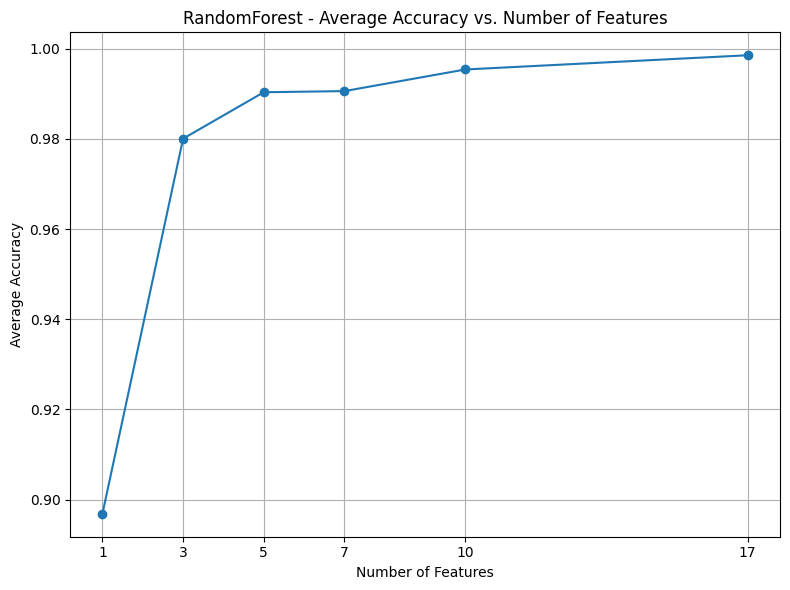

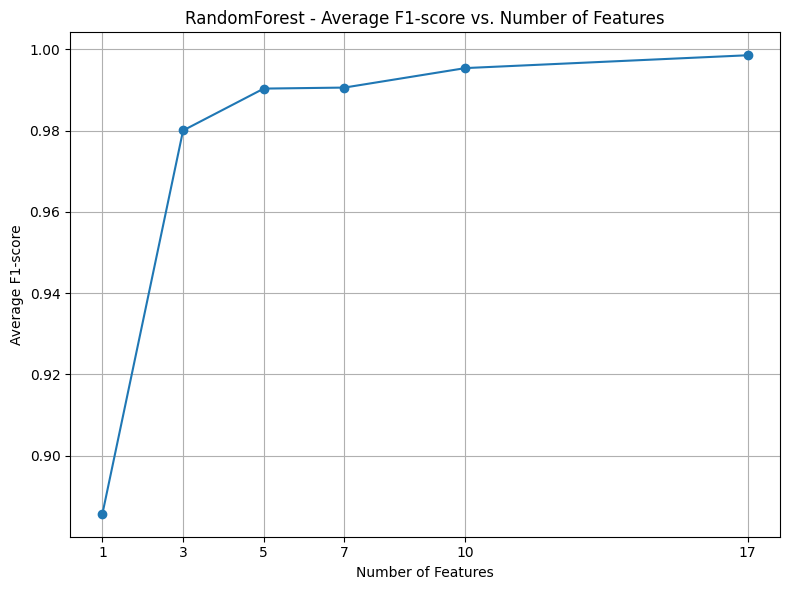

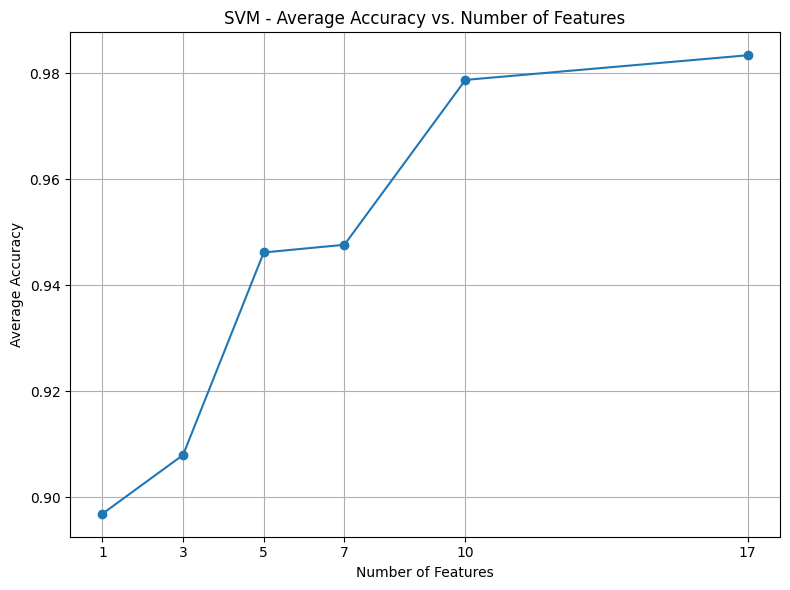

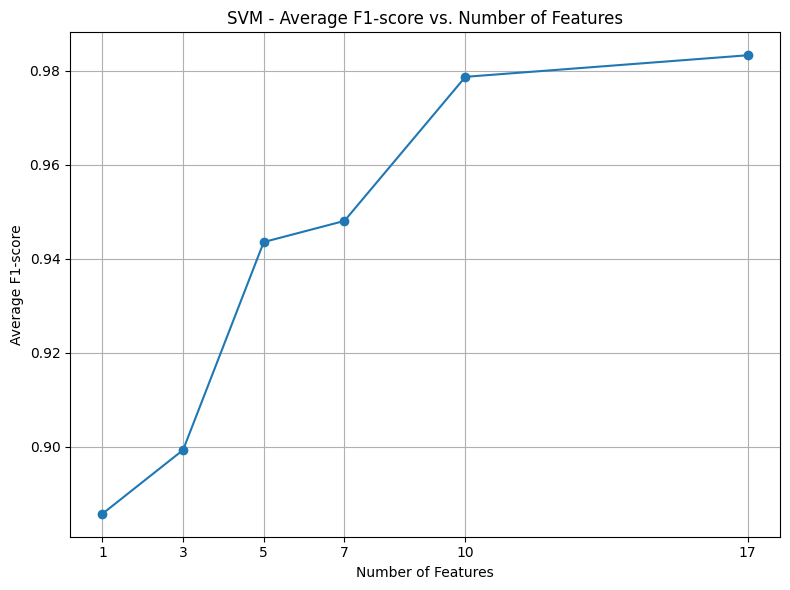

In [10]:
# Define a function to create XY plots
def plot_xy(num_features_list, metric_means, metric_name, classifier_name):
    plt.figure(figsize=(8, 6))
    plt.plot(num_features_list, metric_means, marker='o', linestyle='-')
    plt.title(f"{classifier_name} - Average {metric_name} vs. Number of Features")
    plt.xlabel("Number of Features")
    plt.ylabel(f"Average {metric_name}")
    plt.grid(True)
    plt.xticks(num_features_list)
    plt.tight_layout()
    plt.show()

# Plot RandomForest results
plot_xy(num_features_list, rf_accuracy_means, "Accuracy", "RandomForest")
plot_xy(num_features_list, rf_f1_means, "F1-score", "RandomForest")

# Plot SVM results
plot_xy(num_features_list, svm_accuracy_means, "Accuracy", "SVM")
plot_xy(num_features_list, svm_f1_means, "F1-score", "SVM")